In [1]:
import pandas as pd
from tickets.utils import *
from tickets.stack_overlflow import * 
from collections import Counter
import numpy as np
import statsmodels.api as sm
import matplotlib
import warnings
import itertools
from pylab import rcParams


In [2]:
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

In [3]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
df = load_and_preprocess_so_tickets_data("stackoverflow-data-idf.json", tqdmnb=True)

Schema:

 accepted_answer_id          float64
answer_count                  int64
body                         object
comment_count                 int64
community_owned_date         object
creation_date                object
favorite_count              float64
id                            int64
last_activity_date           object
last_edit_date               object
last_editor_display_name     object
last_editor_user_id         float64
owner_display_name           object
owner_user_id               float64
post_type_id                  int64
score                         int64
tags                         object
title                        object
view_count                    int64
dtype: object
Number of questions,columns= (20000, 19)



Cleaning body texts: 



Cleaning title texts: 


In [5]:
X_train_counts, X_train_tfidf, count_vectorizer, tfidf_transformer = train_so_tfidf(df)

In [6]:
idf_dict = dict(zip(count_vectorizer.get_feature_names(), tfidf_transformer.idf_))

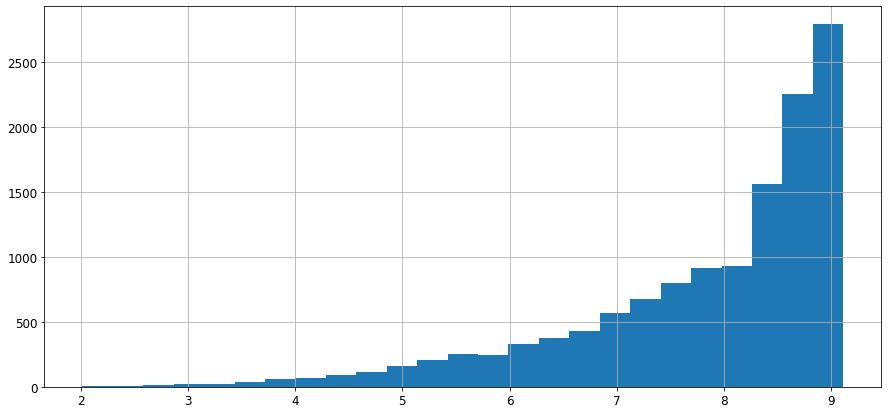

In [7]:
idf = pd.DataFrame(columns=['idf']).from_dict(dict(idf_dict), orient='index')
idf.columns = ['idf']
idf.idf.hist(bins=25, figsize=(15,7))

In [8]:
show_random_so_ticket(df, count_vectorizer, tfidf_transformer)


=====Title=====
How can I disable swift-Mixpanel on development?

=====Body=====
<p>On appDelegate, I used to write like this on obj-c, but in swift, it will crash on development when the app call Mixpanel.mainInstance().track(event: "")</p>

<p>What is a good way not to send mixpanel data on development mode?</p>

<pre><code>#if DEBUG
#else
    Mixpanel.initialize(token: Key.Mixpanel.token)
#endif
</code></pre>

===Tags===

swift|mixpanel

===Keywords===
development: 0.518
swift: 0.379
token: 0.347
appdelegate: 0.238
endif: 0.212
crash: 0.208
track: 0.194
disable: 0.184
obj: 0.183
initialize: 0.178
mode: 0.162
debug: 0.156
good: 0.142
send: 0.142
event: 0.136
key: 0.128
write: 0.126
used: 0.115
app: 0.105
way: 0.088


In [9]:
def show_top_tags(tickets_df):
    tag_counter = Counter()
    for index, item in tickets_df.iterrows():
        for tag in item['tags'].split("|"):
            tag_counter[tag] += 1
    k = 50
    labels, values = zip(*tag_counter.most_common(k))
    indexes = range(len(labels))
    width = 0.80
    
    plt.figure(figsize=(15,10))
    plt.bar(indexes, values, width)
    plt.title("Top {} tags".format(k))
    #plt.xticks(indexes + width * 0.5, labels, rotation=90)
    plt.xticks(indexes, labels, rotation=90)
    plt.show()            

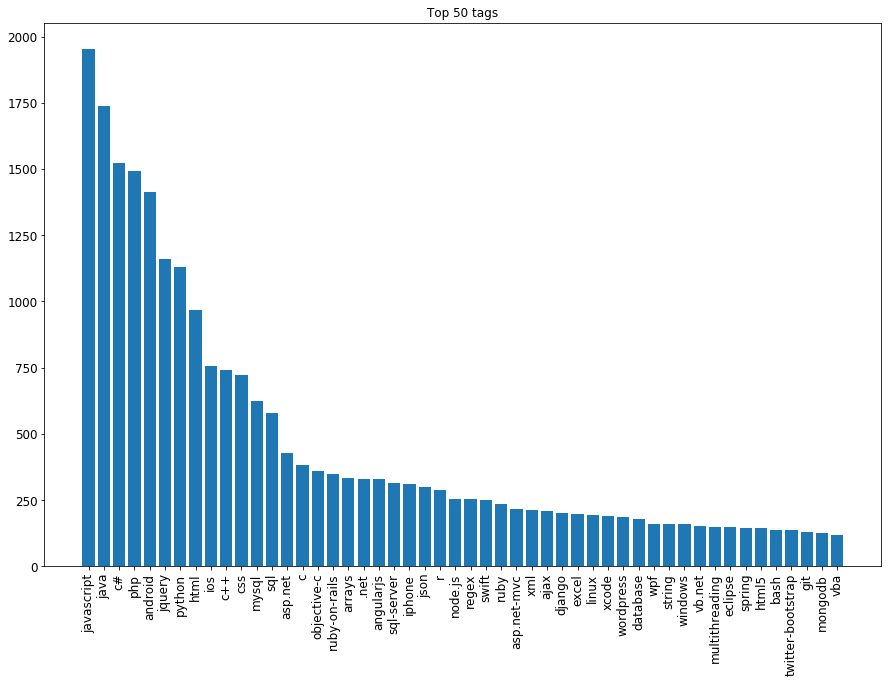

In [10]:
show_top_tags(df)

In [11]:
def tag_timeline(tickets_df, tag, show_plot=True):
    python_df = df[df['tags'].str.contains(r''+tag)][['creation_date', 'id']]
    python_df['creation_date'] =  pd.to_datetime(python_df['creation_date'], infer_datetime_format=True)
    # python_df['creation_date'].min(), python_df['creation_date'].max()
    python_di_df = python_df.set_index('creation_date')
    y = python_di_df['id'].resample('MS').count()
    if show_plot:
        ax = y.plot(figsize=(15, 6))
        ax.set_ylabel('Number of tickets')
        plt.title("Timeline of {} tags".format(tag))
        plt.show()
    return y
    

c:\users\z003vy1z\appdata\local\continuum\anaconda3\envs\nnpy3.6\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



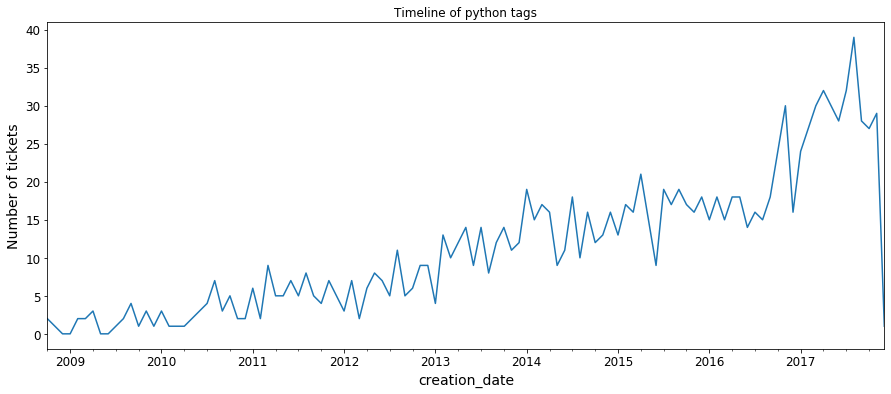

In [12]:
python_ts = tag_timeline(df, 'python')

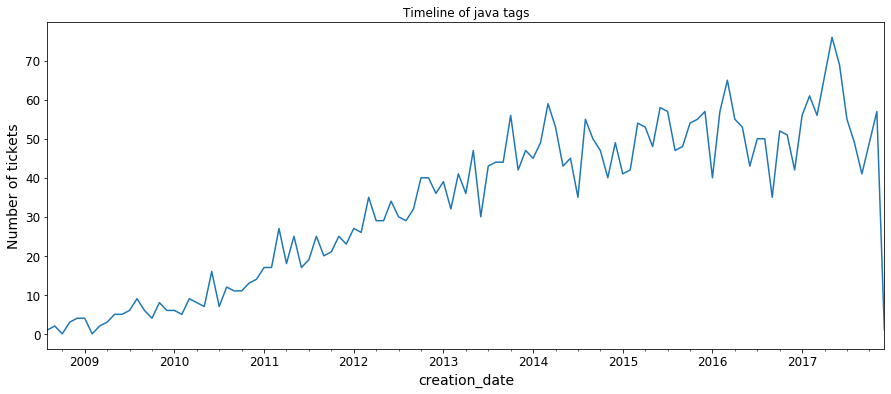

In [13]:
java_ts = tag_timeline(df, 'java')

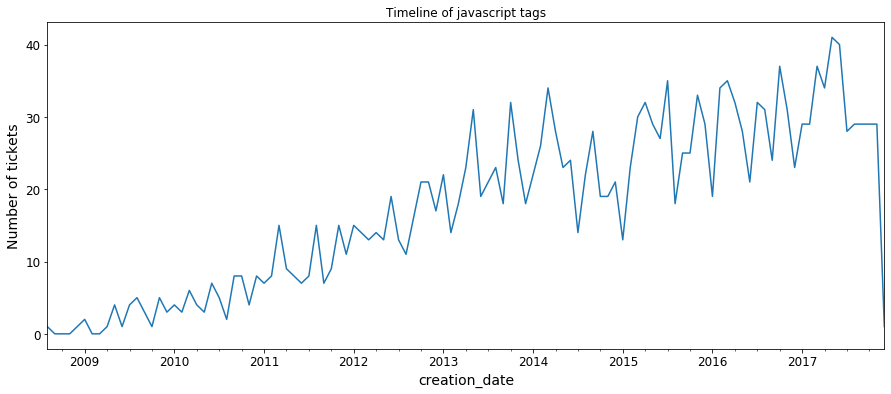

In [14]:

javascript_ts = tag_timeline(df, 'javascript')

In [15]:
def show_trend_seasonality(tickets_df, tag):
    y = tag_timeline(tickets_df, tag, show_plot=False)
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    fig = decomposition.plot()
    fig.suptitle("Tag: {}".format(tag), fontsize=16)
    plt.show()    

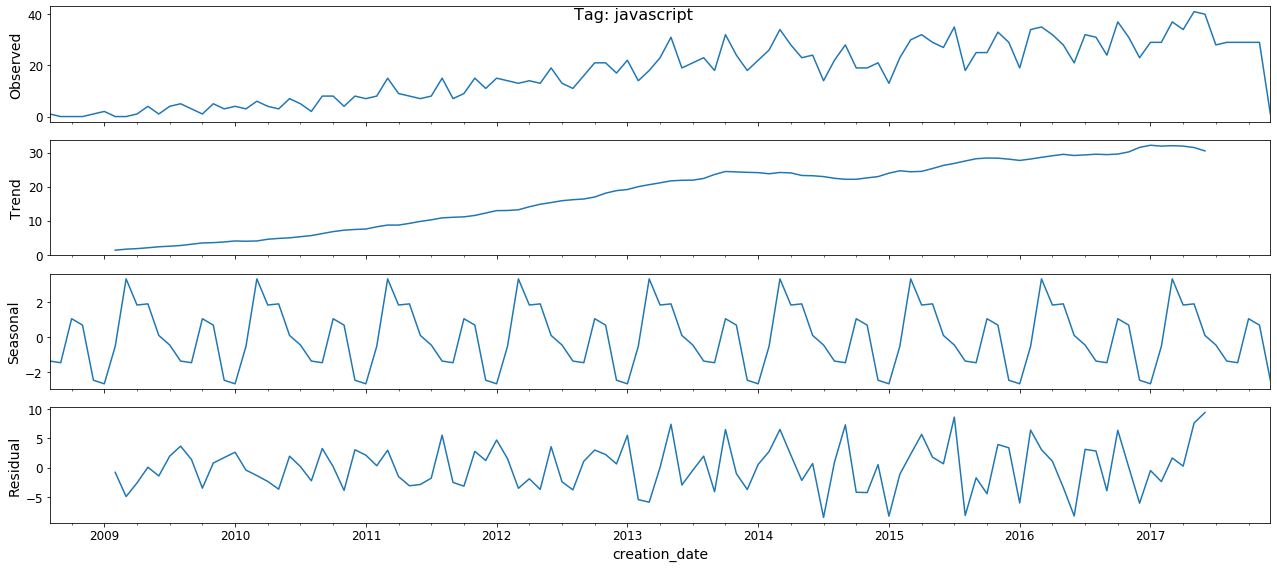

In [16]:
show_trend_seasonality(df, "javascript")

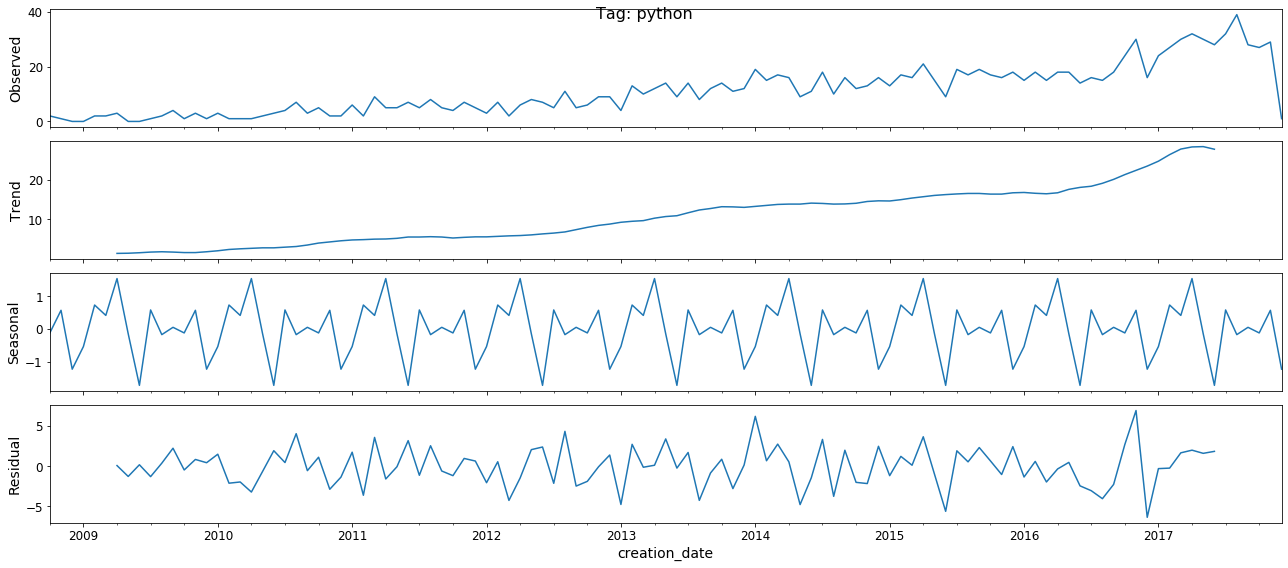

In [17]:
show_trend_seasonality(df, "python")

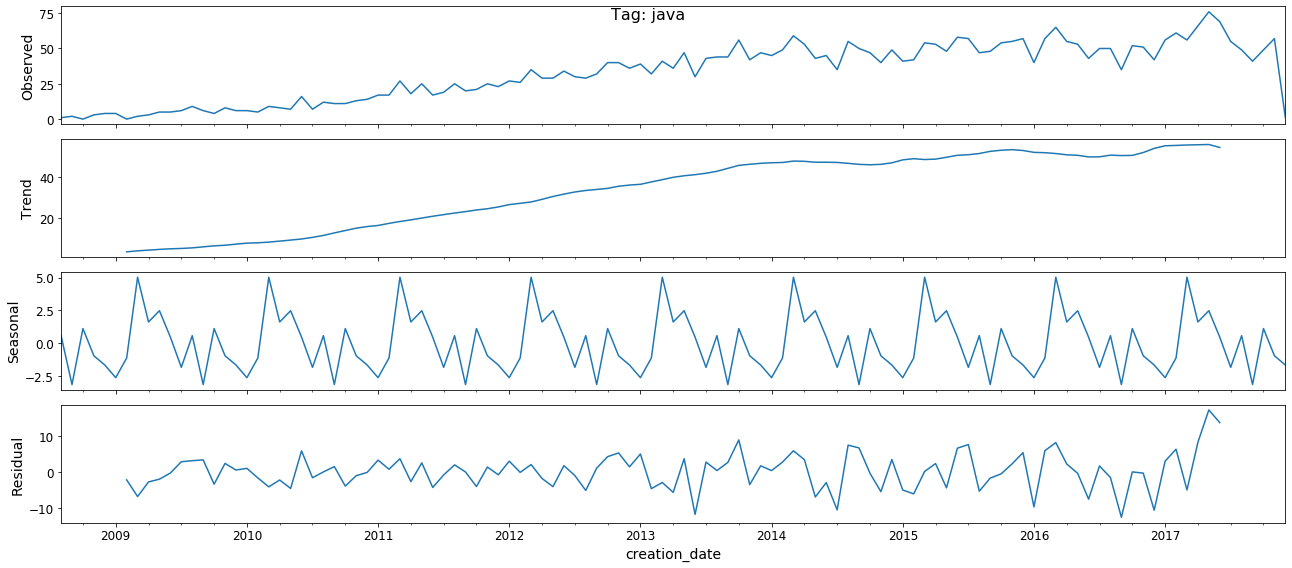

In [18]:
show_trend_seasonality(df, "java")

In [19]:
def train_sarimax(tag_name, tag_timeseries_df, show_diagnostics=False):
    # parameter estimation, simple approach
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]    

    min_aic = float('inf')
    min_params = None
    min_order = None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    tag_timeseries_df,
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = mod.fit()
                if min_aic > results.aic:
                    min_aic = results.aic
                    min_order = param
                    min_params = param_seasonal
                # print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print("========= Model for {} =========".format(tag_name))
    print('ARIMA{}x{}12 - Min AIC:{}\n'.format(min_order, min_params, min_aic))
    # training the SARIMAX model
    mod = sm.tsa.statespace.SARIMAX(tag_timeseries_df,
                                    order=min_order,
                                    seasonal_order=min_params,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    if show_diagnostics:
        results.plot_diagnostics(figsize=(16, 8))
        plt.title("Diagnostics for {} tag time-series model".format(tag_name))
        plt.show()
        
    return results

========= Model for python =========
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - Min AIC:510.84158035414197

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6052      0.112     -5.415      0.000      -0.824      -0.386
ma.S.L12      -0.6897      0.159     -4.328      0.000      -1.002      -0.377
sigma2        23.0337      2.231     10.322      0.000      18.660      27.407


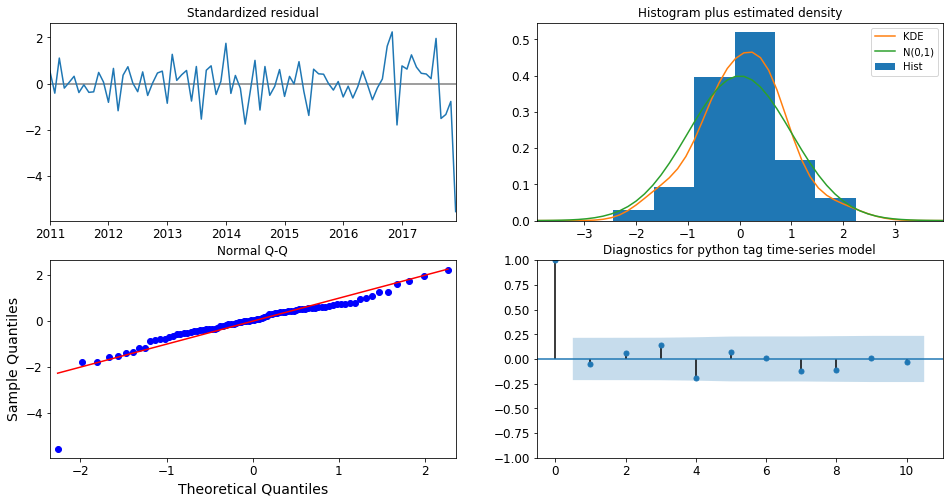

In [20]:
model_python = train_sarimax("python", python_ts, True)

========= Model for java =========
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - Min AIC:631.9702716595885

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6487      0.125     -5.174      0.000      -0.894      -0.403
ma.S.L12      -0.6229      0.151     -4.117      0.000      -0.919      -0.326
sigma2        83.0005      6.379     13.012      0.000      70.499      95.502


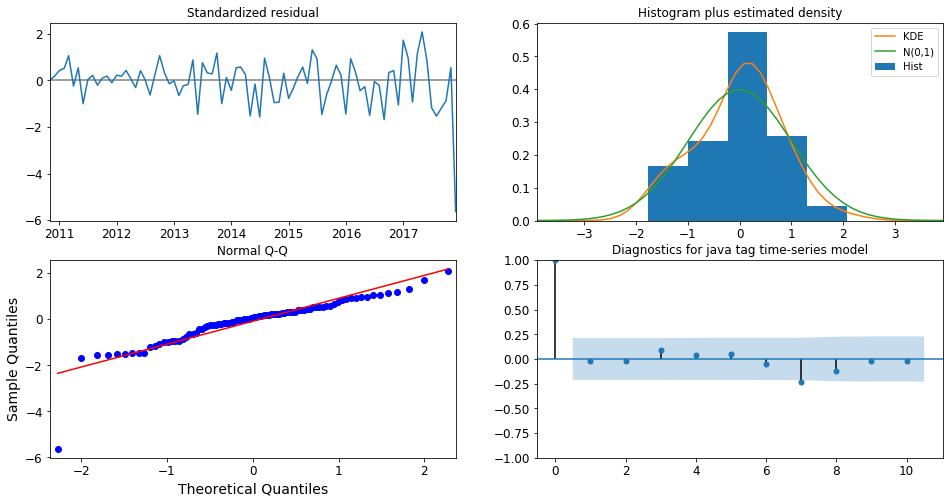

In [21]:
model_java = train_sarimax("java", java_ts, True)

========= Model for javascript =========
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - Min AIC:561.9775633847796

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8151      0.102     -7.965      0.000      -1.016      -0.615
ma.S.L12      -0.7578      0.135     -5.605      0.000      -1.023      -0.493
sigma2        35.5860      4.572      7.784      0.000      26.625      44.547


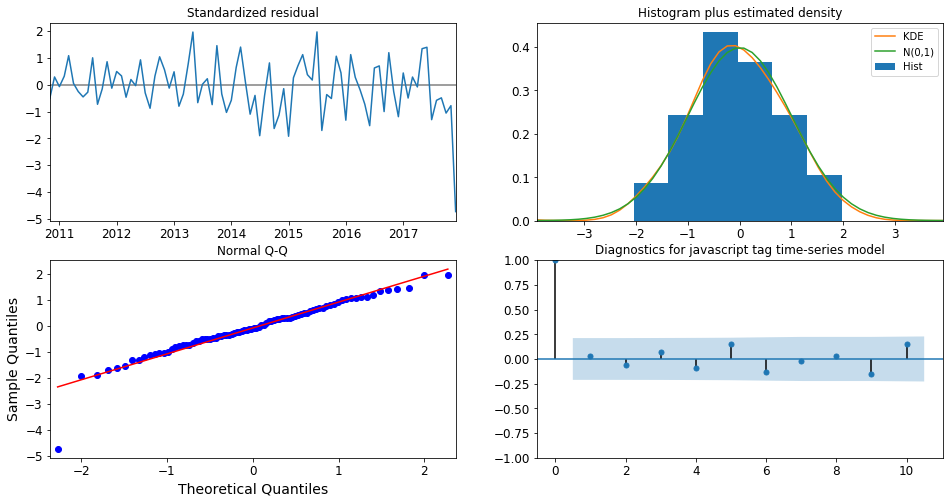

In [22]:
model_javascript = train_sarimax("javascript", javascript_ts, True)

In [27]:
def predict_tag_timeline(tag_name, tag_timeseries_df, model, pred_start_date='2016-01-01', plot_start_year='2014'):

    pred = model.get_prediction(start=pd.to_datetime(pred_start_date).tz_localize('UTC'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = tag_timeseries_df[plot_start_year:].plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of tickets')
    plt.title("Timeline of the {} tag".format(tag_name))
    plt.legend()
    plt.show()

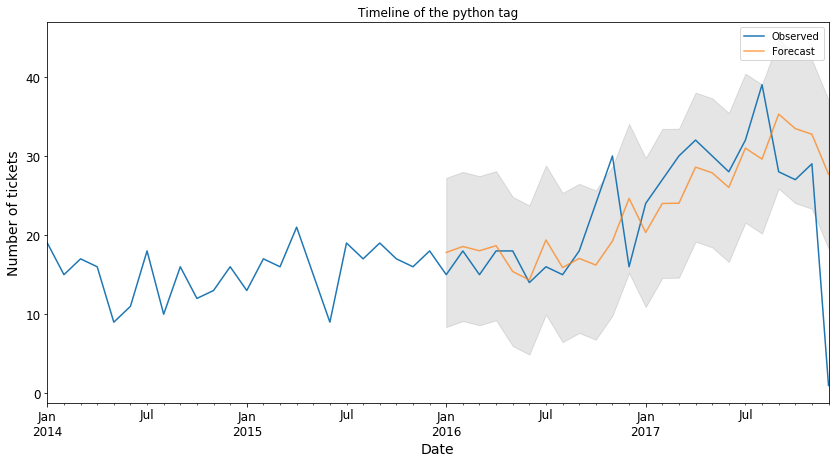

In [28]:
predict_tag_timeline('python', python_ts, model_python)

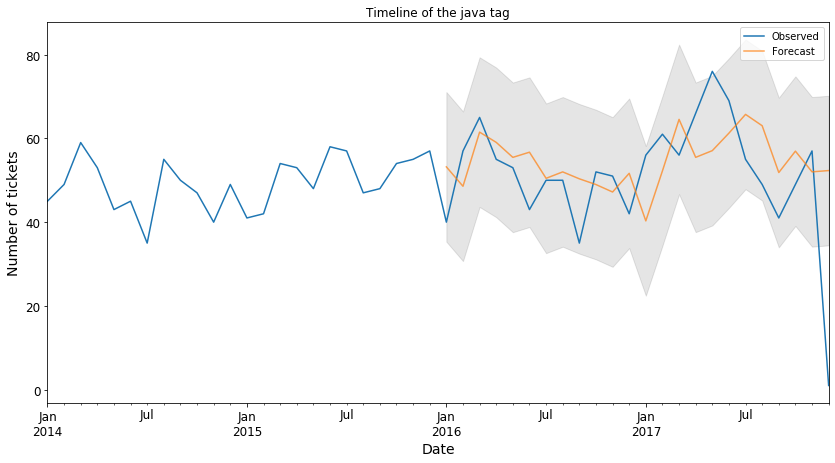

In [29]:
predict_tag_timeline('java', java_ts, model_java)

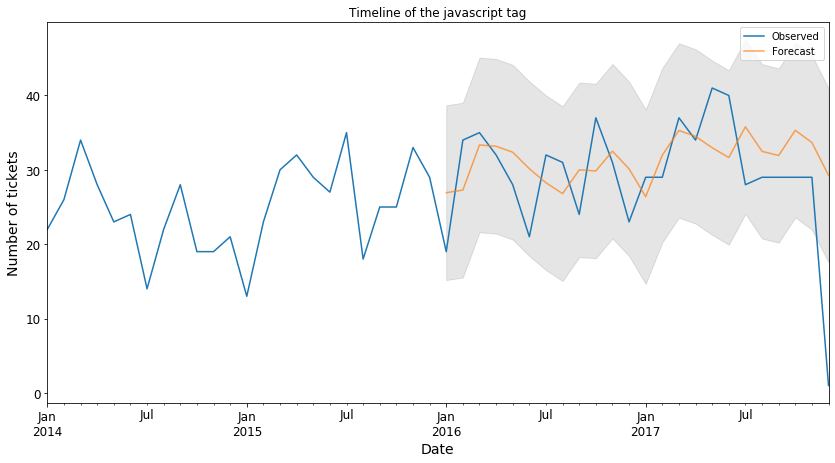

In [30]:
predict_tag_timeline('javascript', javascript_ts, model_javascript)